# Intro

https://www.kaggle.com/c/learn-together

My attempt at the contest, upvoted kernels, which I found useful.

# Versioning

* Version: V5
* Description: 
  - Correlation matrix
  - Added Heatmap
  - No drop low correlation columns
  - Hyperparameter optimization for RandomForest, KNN
  - Manual stacking
  - Added TOC and stacking info

# Table of contents <a id="0"></a>

* [Imports](#imports)
* [Block selection](#block-selection)
* [Identify important features](#identify-important-features)
* [Define models](#define-models)
* [Base estimators grid search](#base-estimators-grid-search)
* [Stacking intro](#stacking-intro)
* [Generate output](#generate-output)

In [1]:
dir = !ls -a
if ('kernel-metadata.json' in dir):
    src = 'Local'
    # Local environment
    data_path = './data/learn-together'
else:
    # Kaggle environment
    src = 'Kaggle'
    data_path = '../input'

print('Environment set to [{env}]'.format(env=src))

Environment set to [Local]


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Imports <a id="imports"></a>
[Go back to top](#0)

In [1]:
# Suppress future defaults warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# System imports
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Utilities
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Block selection <a id="block-selection"></a>
[Go back to top](#0)

In [4]:
get_feature_importances = 1
generate_heatmap = 1
drop_low_correlation_features = 0
run_grid_search_for_base_estimators = 1
generate_output = 1

grid_search_n_splits = 5
low_correlation_features = ['Aspect', 'Hillshade_9am']

In [5]:
df_test = pd.read_csv(data_path + '/test.csv')
df_sample_submission = pd.read_csv(data_path + '/sample_submission.csv')
df = pd.read_csv(data_path + '/train.csv')
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [6]:
# Identify columns with only 1 value, these are unlikely to be helpful
col_singular = [col for col in df.columns if df[col].nunique() == 1]
print('Singular columns: {}'.format(col_singular))

# Drop singular columns
df.drop(col_singular, axis=1, inplace=True)
df_test.drop(col_singular, axis=1, inplace=True)

Singular columns: ['Soil_Type7', 'Soil_Type15']


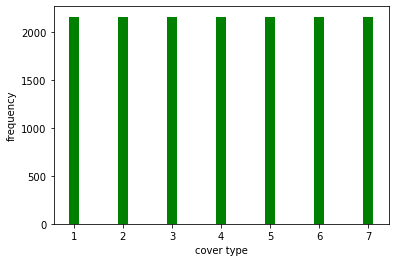

In [7]:
# Check if target types are evenly spread
plt.ylabel('frequency')
plt.xlabel('cover type')
plt.bar(df['Cover_Type'].unique(), df['Cover_Type'].value_counts(), color ='green', width=0.2)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

# Evenly distributed, that's great**

# Identify important features <a id="identify-important-features"></a>
[Go back to top](#0)

In [8]:
if get_feature_importances:
    target = 'Cover_Type'
    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[target]

    bestfeatures = SelectKBest(k=10)
    fit = bestfeatures.fit(X, y)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score'] 
    print(featureScores.nlargest(20,'Score'))

                                 Specs         Score
1                            Elevation  16241.233317
14                    Wilderness_Area4   5072.497908
6      Horizontal_Distance_To_Roadways   1223.070458
23                         Soil_Type10    977.737621
17                          Soil_Type3    929.217593
11                    Wilderness_Area1    928.831132
10  Horizontal_Distance_To_Fire_Points    746.124576
50                         Soil_Type38    744.906554
51                         Soil_Type39    640.529899
13                    Wilderness_Area3    444.959975
52                         Soil_Type40    422.043458
7                        Hillshade_9am    378.220751
4     Horizontal_Distance_To_Hydrology    375.897228
42                         Soil_Type30    352.446574
41                         Soil_Type29    341.825668
3                                Slope    301.849051
18                          Soil_Type4    248.325587
34                         Soil_Type22    233.

[6.42275328e-02 1.34899148e-01 4.43905282e-02 3.65233697e-02
 5.51443736e-02 4.28382707e-02 7.55553616e-02 4.45680974e-02
 3.96256676e-02 4.19758877e-02 6.11583205e-02 2.16699403e-02
 2.53378779e-03 1.38158205e-02 6.89108205e-02 1.82302480e-03
 8.37256397e-03 2.67778185e-02 1.59762074e-02 1.61891565e-03
 4.23137105e-03 3.79236035e-05 1.14619299e-04 3.14595608e-02
 5.00015715e-03 6.11338920e-03 8.78700526e-03 1.85758731e-03
 1.85050631e-03 8.52319003e-03 9.88226586e-04 6.45320758e-04
 2.15984827e-03 3.97392074e-04 7.19119752e-03 7.44626461e-03
 4.26118232e-03 4.14578587e-05 6.66686058e-04 2.42509402e-04
 1.28822651e-04 6.92717372e-03 1.11386874e-02 4.53149783e-03
 6.23900585e-03 5.76406415e-03 4.62227476e-04 3.61943356e-03
 2.75656151e-04 1.56105290e-03 2.79595143e-02 2.21175957e-02
 1.48544154e-02]


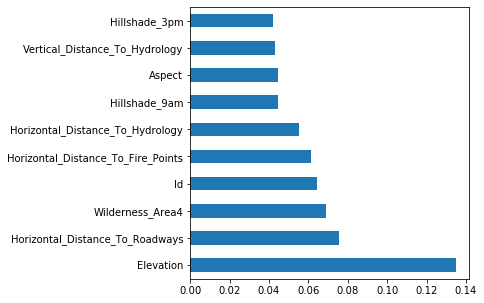

In [9]:
if get_feature_importances:
    model = ExtraTreesClassifier()
    model.fit(X,y)
    print(model.feature_importances_) 
    
    # plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

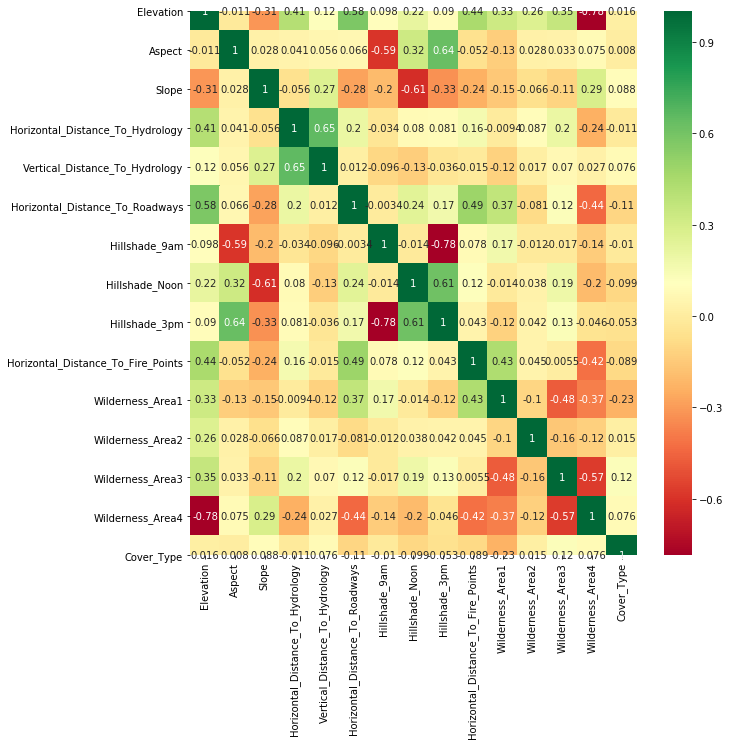

In [10]:
if generate_heatmap:
    # Get correlation to see if dimensionality can be reduced. 
    # Only considering non-categorical columns for simplicity
    df_subset = df[['Elevation', 'Aspect', 'Slope',
           'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
           'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
           'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
           'Wilderness_Area4', 'Cover_Type']]

    corrmat = df_subset.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(10,10))
    g=sns.heatmap(df_subset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [11]:
# Drop low correlation feature
if drop_low_correlation_features:
    df.drop(low_correlation_features, axis=1, inplace=True)
    df_test.drop(low_correlation_features, axis=1, inplace=True)

In [12]:
# Separate features and target
target = 'Cover_Type'
features = list(df.columns)
features.remove(target)

X = df[features]
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, train_size=0.8)

# Define models <a id="define-models"></a>
[Go back to top](#0)

In [13]:
# Define Base (level 0) and Stacking (level 1) estimators
base_models = []

model = {'model': AdaBoostClassifier(random_state=5)}
parameters = {}
model['parameters'] = parameters
model['grid_search'] = 0
base_models.append(model)

model = {'model': SVC(probability=True, random_state=5, gamma='scale')}
parameters = {}
model['parameters'] = parameters
model['grid_search'] = 0
base_models.append(model)

model = {'model': XGBClassifier(random_state=5)}
parameters = {}
model['parameters'] = parameters
model['grid_search'] = 0
base_models.append(model)

model = {'model': RandomForestClassifier(n_estimators=100, random_state = 5)}
parameters = {'n_estimators': [100, 150, 200, 400, 600, 800, 1000, 1100]}
model['parameters'] = parameters
model['grid_search'] = 1
base_models.append(model)

model = {'model': KNeighborsClassifier()}
parameters = {'n_neighbors': range(3,12,2), 
              'weights': ['uniform', 'distance']}
model['parameters'] = parameters
model['grid_search'] = 1
base_models.append(model)

#model = {'model': LogisticRegression(random_state=5)}
#parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
#model['parameters'] = parameters
#model['grid_search'] = 1
#base_models.append(model)

# Define Stacking estimator
stack_model = RandomForestClassifier(n_estimators=600, random_state=5)

In [14]:
# Evaluate Base estimators separately
for base_model in base_models:
    model = copy.deepcopy(base_model['model'])
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    print('{} Accuracy: {:.2f}%'.format(model.__class__.__name__, acc * 100))

AdaBoostClassifier Accuracy: 34.56%
SVC Accuracy: 56.35%
XGBClassifier Accuracy: 76.22%
RandomForestClassifier Accuracy: 88.19%
KNeighborsClassifier Accuracy: 82.08%


# Base models grid search <a id="base-models-grid-search"></a>
[Go back to top](#0)

In [15]:
# Do grid search on each base model
if run_grid_search_for_base_estimators:
    for base_model in base_models:
        if base_model['grid_search']:
            print('Model: {model_name}'.format(model_name=base_model['model'].__class__.__name__))
            print('Optimizing parameters: [{params}]'.format(params=base_model['parameters']))
            kfold = KFold(n_splits=grid_search_n_splits, shuffle=True)
            CV = GridSearchCV(base_model['model']
                          , param_grid=base_model['parameters']
                          , scoring = 'accuracy'
                          , n_jobs=-1
                          , cv=kfold)
            CV.fit(X_train, y_train)
            best_model = CV.best_estimator_
            base_model['best_model'] = best_model
            print('Best score and parameter combination = ')
            print(CV.best_score_)    
            print(CV.best_params_) 
            print('\n')

for base_model in base_models:
    if 'best_model'not in base_model:
        base_model['best_model'] = base_model['model']

NameError: name 'run_grid_search_for_base_estimators' is not defined

In [ ]:
if run_grid_search_for_base_estimators:
    for base_model in base_models:
        if base_model['grid_search']:
            model = copy.deepcopy(base_model['best_model'])
            print('After grid search: ')
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            print('{} Accuracy: {:.2f}%\n'.format(model.__class__.__name__, acc * 100))

# Stacking intro <a id="stacking-intro"></a>
[Go back to top](#0)

## Layer 1
1. Layer 1, loop across folds
  - Separate X and y into training and validation sets. Keep validation set aside and ignore for now
  - For the first base model, split the training data into n folds
  - Fit the base model on X_train, y_train from n-1 folds, and predict on the remaining nth fold. 
  - Add the predictions into a meta series for the base model
2. Repeat (2), n times, each time with new nth fold. This will cover full training data. Will then end up with predictions for all n folds (full training data) in the meta seies (number of rows same as X_train)
3. Loop across models
  - Repeat (1) and (2) for all base models
  - Combine meta series for each base model into meta df - one column per base model, number of rows same as original training data. 
5. Optionally add an original feature from the training data into the meta dataframe
6. This dataframe is feature data for next stage

## Layer 2
7. Fit the stacking model on the meta Dataframe (output of (6)) and y_train. This is our stacked model. The purpose of fitting base models fold-wise is to get a more accurate stacked model

## Validation
8. Fit first base model on the full input data (X, y). Predict on X_val, this will generate a meta series
9. Repeat (8) across each base model, combine output series from each base model to make meta dataframe for next layer
10. Add the same feature column (as in (5)), from X_val into the meta dataframe from (9). This is source for next layer
11. Predict using stacked model (output of (7)) on the output of (10)
12. Compare prediction from (11) with y_val to get score

## Testing
13. Repeat steps (8), (9), (10), (11), this time using df_test in place of X_val

In [ ]:
# Create first level predictions (meta-features)
def hold_out_predict(clf, X, y, cv):
        
    """Performing cross validation hold out predictions for stacking"""
    # Initilize
    n_classes = len(np.unique(y)) # Assuming that training data contains all classes
    meta_features = np.zeros((X.shape[0], n_classes)) 
    n_splits = cv.get_n_splits(X, y)
    
    # Loop over folds
    print("Starting hold out prediction with {} splits for {}.".format(n_splits, clf.__class__.__name__))
    for train_idx, hold_out_idx in cv.split(X): 
        
        # Split data
        X_train = X.iloc[train_idx]    
        y_train = y.iloc[train_idx]
        X_hold_out = X.iloc[hold_out_idx]

        # Fit estimator to K-1 parts and predict on hold out part
        est = copy.deepcopy(clf)
        est.fit(X_train, y_train)
        y_hold_out_pred = est.predict_proba(X_hold_out)
        
        # Fill in meta features
        meta_features[hold_out_idx] = y_hold_out_pred

    return meta_features

In [ ]:
# Create first level predictions (meta-features) from training data

# Define folds
kfold = KFold(n_splits=layer_one_folds, shuffle=True)

# Loop over classifier to produce meta features
meta_train = pd.DataFrame()
for base_model in base_models:
    
    model = copy.deepcopy(base_model['best_model'])
    # Create hold out predictions for a classifier
    meta_train_model = hold_out_predict(model, X_train, y_train, kfold)
    #print(pd.DataFrame(meta_train_model).head())
    
    # Gather meta training data
    meta_train = pd.concat([meta_train, pd.DataFrame(meta_train_model)], axis=1)
    #print(pd.DataFrame(meta_train).head())

stack_model.fit(meta_train, y_train)

# Generate output <a id="generate-output"></a>
[Go back to top](#0)

In [ ]:
# Create meta-features for testing data
if generate_output:
    meta_test = pd.DataFrame()
    for base_model in base_models:
        model = copy.deepcopy(base_model['best_model'])
        
        # Fit model
        model.fit(X_train, y_train)
        meta_test_model = model.predict_proba(df_test)
    
        # Gather meta training data
        meta_test = pd.concat([meta_test, pd.DataFrame(meta_test_model)], axis=1)
    
    # Final output
    preds = stack_model.predict(meta_test)

    # Save test predictions to file
    output = pd.DataFrame({'Id': df_sample_submission.Id,
                   'Cover_Type': preds})
    output.head()
    output.to_csv('submission.csv', index=False)